<a href="https://colab.research.google.com/github/stevejj4/Insurance-data-lifecycle/blob/main/claims_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-cloud-bigquery
!pip install pyspark==3.1.2

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
from pyspark.sql import SparkSession

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880745 sha256=818b7ddaa19067582ece148a2ded3dda212b037cd9900567653cb198cae81321
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
# Authenticating and initializing BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)

In [5]:
# Querying to get interactions table
query_claims = """
SELECT * FROM `river-messenger-430112-e1.Insurance_data.claims`;
"""

In [6]:
# Executing the query and converting to a pandas DataFrame
df_claims = client.query(query_claims).to_dataframe()

In [7]:
# Initializing SparkSession
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .getOrCreate()

# Converting pandas DataFrame to Spark DataFrame
# Using iterrows() instead of iteritems() to iterate over DataFrame rows
spark_df_claims = spark.createDataFrame(df_claims.to_dict('records'))

# Show the schema and first few rows
spark_df_claims.printSchema()
spark_df_claims.show(5)

root
 |-- ClaimAmount: double (nullable = true)
 |-- ClaimDate: string (nullable = true)
 |-- ClaimID: long (nullable = true)
 |-- ClaimStatus: string (nullable = true)
 |-- CustomerID: long (nullable = true)

+-----------+----------+-------+-----------+----------+
|ClaimAmount| ClaimDate|ClaimID|ClaimStatus|CustomerID|
+-----------+----------+-------+-----------+----------+
|   16550.85|2022-07-19|   2053|    Pending|      1278|
|    7218.45|2022-07-19|   2957|    Pending|       989|
|    1081.17|2022-07-20|    120|    Pending|      1228|
|     3149.5|2022-07-20|   1285|    Pending|      1048|
|    2712.05|2022-07-21|   1953|    Pending|      1570|
+-----------+----------+-------+-----------+----------+
only showing top 5 rows



In [8]:
spark_df_claims.select("ClaimAmount").describe().show()

+-------+-----------------+
|summary|      ClaimAmount|
+-------+-----------------+
|  count|             3000|
|   mean|10140.84765666668|
| stddev|5591.086391698572|
|    min|           526.12|
|    max|         19994.66|
+-------+-----------------+



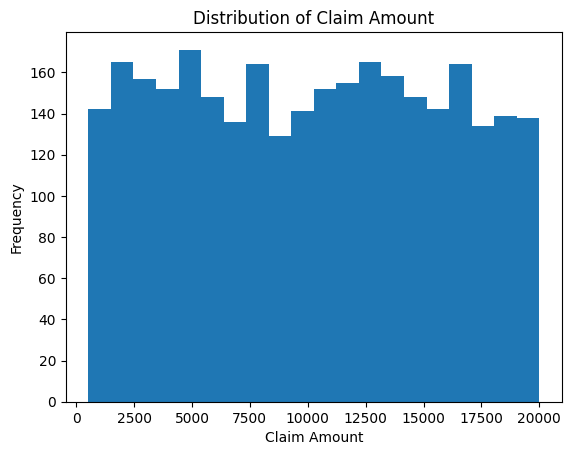

In [9]:
import matplotlib.pyplot as plt
# Assuming 'ClaimAmount' is a numeric column
claim_amounts = spark_df_claims.select("ClaimAmount").rdd.flatMap(lambda x: x).collect()
plt.hist(claim_amounts, bins=20)
plt.xlabel("Claim Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Claim Amount")
plt.show()

In [13]:
from pyspark.sql.functions import year, month, dayofmonth

spark_df_claims = spark_df_claims.withColumn("ClaimYear", year("ClaimDate")) \
                                 .withColumn("ClaimMonth", month("ClaimDate")) \
                                 .withColumn("ClaimDay", dayofmonth("ClaimDate"))

spark_df_claims.show()

+-----------+----------+-------+-----------+----------+---------+----------+--------+
|ClaimAmount| ClaimDate|ClaimID|ClaimStatus|CustomerID|ClaimYear|ClaimMonth|ClaimDay|
+-----------+----------+-------+-----------+----------+---------+----------+--------+
|   16550.85|2022-07-19|   2053|    Pending|      1278|     2022|         7|      19|
|    7218.45|2022-07-19|   2957|    Pending|       989|     2022|         7|      19|
|    1081.17|2022-07-20|    120|    Pending|      1228|     2022|         7|      20|
|     3149.5|2022-07-20|   1285|    Pending|      1048|     2022|         7|      20|
|    2712.05|2022-07-21|   1953|    Pending|      1570|     2022|         7|      21|
|    4713.42|2022-07-21|   2783|    Pending|      1758|     2022|         7|      21|
|   12446.76|2022-07-22|    780|    Pending|      1608|     2022|         7|      22|
|    6117.53|2022-07-23|    656|    Pending|      1781|     2022|         7|      23|
|     4126.7|2022-07-24|   2474|    Pending|      1775

In [15]:
from pyspark.sql.functions import month

spark_df_claims = spark_df_claims.withColumn("ClaimMonth", month("ClaimDate"))

spark_df_claims.show()

+-----------+----------+-------+-----------+----------+---------+----------+--------+
|ClaimAmount| ClaimDate|ClaimID|ClaimStatus|CustomerID|ClaimYear|ClaimMonth|ClaimDay|
+-----------+----------+-------+-----------+----------+---------+----------+--------+
|   16550.85|2022-07-19|   2053|    Pending|      1278|     2022|         7|      19|
|    7218.45|2022-07-19|   2957|    Pending|       989|     2022|         7|      19|
|    1081.17|2022-07-20|    120|    Pending|      1228|     2022|         7|      20|
|     3149.5|2022-07-20|   1285|    Pending|      1048|     2022|         7|      20|
|    2712.05|2022-07-21|   1953|    Pending|      1570|     2022|         7|      21|
|    4713.42|2022-07-21|   2783|    Pending|      1758|     2022|         7|      21|
|   12446.76|2022-07-22|    780|    Pending|      1608|     2022|         7|      22|
|    6117.53|2022-07-23|    656|    Pending|      1781|     2022|         7|      23|
|     4126.7|2022-07-24|   2474|    Pending|      1775

Number of distinct ClaimStatus classes: 3


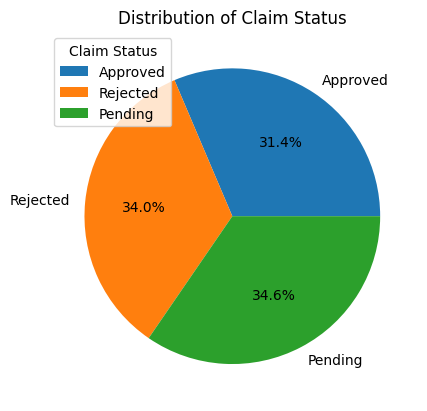

In [19]:
num_classes = spark_df_claims.select("ClaimStatus").distinct().count()
print("Number of distinct ClaimStatus classes:", num_classes)
import matplotlib.pyplot as plt

class_distribution = spark_df_claims.groupBy("ClaimStatus").count().collect()
class_distribution_pandas = pd.DataFrame(class_distribution, columns=["ClaimStatus", "count"])

plt.pie(class_distribution_pandas['count'], labels=class_distribution_pandas['ClaimStatus'], autopct='%1.1f%%')
plt.title("Distribution of Claim Status")
plt.legend(title="Claim Status", loc="best")  # Add this line for the legend
plt.show()


In [24]:
from pyspark.sql.functions import avg

avg_claim_by_status = spark_df_claims.groupBy("ClaimStatus").agg(avg("ClaimAmount").alias("AverageClaimAmount"))
avg_claim_by_status.show()

+-----------+------------------+
|ClaimStatus|AverageClaimAmount|
+-----------+------------------+
|   Approved|10415.465743099789|
|   Rejected|10093.062546523015|
|    Pending| 9938.435274831261|
+-----------+------------------+



In [23]:
from pyspark.sql.functions import year

distinct_years = spark_df_claims.select(year("ClaimDate").alias("ClaimYear")).distinct()
distinct_years.show()

+---------+
|ClaimYear|
+---------+
|     2023|
|     2022|
|     2024|
+---------+

